# Projeto 11 - Rede Neural Convolucional MNIST - Aumento de Imagens

# 1. Importando bibliotecas

In [28]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'2.5.0'

In [29]:
torch.set_default_device("mps")
device = torch.device("mps")

# torch.set_default_device("cpu")
# device = torch.device("cpu")

In [30]:
print(torch.backends.mps.is_available())  # Deve retornar True
print(torch.backends.mps.is_built())  # Deve retornar True

True
True


## 2. Importando dados

In [31]:
torch.manual_seed(123)

In [32]:
transform_train = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees = 7, 
                                                              translate = (0, 0.07), # horizontal and vertical shifts
                                                              shear = 7,
                                                              scale = (1, 1.2) # zoom range
                                                              ),
                                      transforms.ToTensor()
                                      ])

In [33]:
transform_test = transforms.ToTensor()

In [36]:
train = datasets.MNIST(root = '.', train = True, download = True, transform = transform_train)
test = datasets.MNIST(root = '.', train = False, download = True, transform = transform_test)

In [38]:
train.data.shape

torch.Size([60000, 28, 28])

In [39]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [40]:
train.data.shape

torch.Size([60000, 28, 28])

In [41]:
28 * 28

784

In [42]:
train.targets[0]

tensor(5)

In [43]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

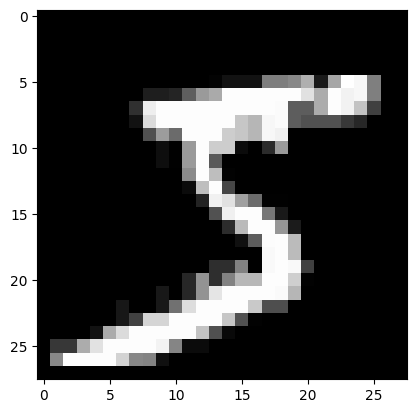

In [44]:
imagem = next(iter(train_loader))[0][0].view(28, 28) # (1, 1, 28, 28) -> quantas imagens, numero de filtros/canais, larg, alt
plt.imshow(imagem, cmap='gray')

(array([602.,  15.,   7.,  15.,   8.,  11.,  13.,  16.,  14.,  83.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.90000004,
        1.        ]),
 <BarContainer object of 10 artists>)

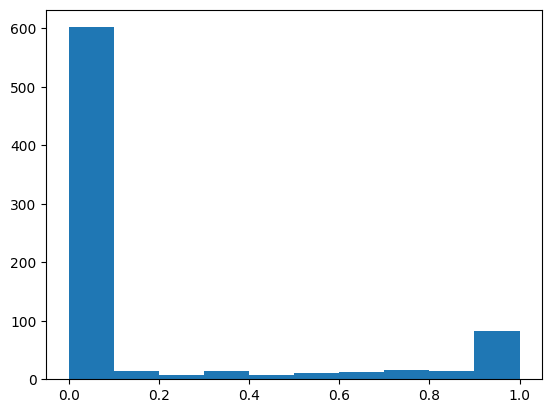

In [45]:
plt.hist(imagem.view(-1))

## 3. Construção do modelo

In [46]:
class classificador(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)) # operador de convolucao
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)) # operador 2 de convolucao
        
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features=32) # normalizacao dos dados em camadas ocultas

        self.pool = nn.MaxPool2d(kernel_size=(2,2))

        self.flatten = nn.Flatten()

        # 800 -> 128
        # output = (input - filter + 1) / (stride)
        # convolucao 1: (28 - 3 + 1) / 1 (stride) = 26
        # pooling 1: 13 x 13
        # convolucao 1: (13 - 3 + 1) / 1 (stride) = 26
        # pooling 2: 5x5
        # 5 * 5 * 32 = imagem (5x5) * quantidade de filtros
        # 800 -> 128 -> 128 -> 10
        
        self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, X):
        
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)

        return X
        

In [47]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## 4. Treinamento do modelo

In [48]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [49]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k=1, dim=1)

        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))
        running_accuracy += accuracy

        print('\rEpoch: {:4d} - Loop {:3d} of {:3d} - Loss: {:6.4f} - Accuracy: {:6.4f}'.format(epoch + 1,
                      i + 1,
                      len(train_loader),
                      loss,                                                                          
                      accuracy), end = '\r')

    print(f"\rEnded Epoch {epoch + 1} - loss: {running_loss/len(loader)} - precision: {running_accuracy/len(loader)} end=\r")

In [50]:
for epoch in range(5):
    print("Training...")
    training_loop(train_loader, epoch)
    
    print("Validating...")
    net.eval()
    training_loop(test_loader, epoch)
    net.train()

Training...


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


Ended Epoch 1 - loss: 0.3879020112648066 - precision: 0.8749167323112488 end=
Validating...
Ended Epoch 1 - loss: 0.11743118302510533 - precision: 0.9670688509941101 end=
Training...
Ended Epoch 2 - loss: 0.15802711297744024 - precision: 0.9518701434135437 end=
Validating...
Ended Epoch 2 - loss: 0.09639711343518258 - precision: 0.9696400165557861 end=
Training...
Ended Epoch 3 - loss: 0.12144695602303772 - precision: 0.9632084965705872 end=
Validating...
Ended Epoch 3 - loss: 0.050332484660740896 - precision: 0.9864517450332642 end=
Training...
Ended Epoch 4 - loss: 0.10947097883001765 - precision: 0.9668176770210266 end=
Validating...
Ended Epoch 4 - loss: 0.039791146062662285 - precision: 0.9877373576164246 end=
Training...
Ended Epoch 5 - loss: 0.09720320015081338 - precision: 0.970810055732727 end=
Validating...
Ended Epoch 5 - loss: 0.03174512252017054 - precision: 0.9908030033111572 end=


## 5. Avaliação do modelo

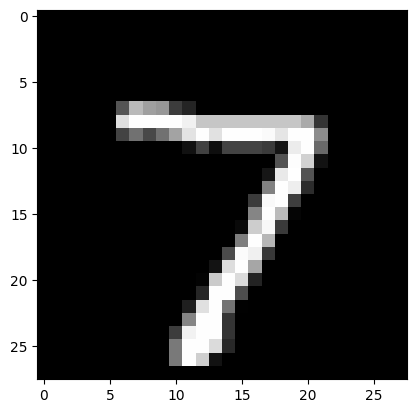

In [51]:
imagem = next(iter(test_loader))[0][0].view(28, 28)
plt.imshow(imagem, cmap="gray")

In [49]:
# (1, 1, 28, 28) - Batch_size, numero de canais, altura, largura
imagem = imagem.view(1, 1, 28, 28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [50]:
net.eval()

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [51]:
imagem = imagem.to(device)

In [52]:
previsao = net.forward(imagem)
previsao

tensor([[ -5.9120,  -3.8219,  -1.6265,  -3.9773,  -1.9425,  -9.2419, -11.0926,
          12.1388,  -7.2283,  -1.9412]], device='mps:0',
       grad_fn=<LinearBackward0>)

In [53]:
previsao = F.softmax(previsao)
previsao

tensor([[1.4476e-08, 1.1704e-07, 1.0515e-06, 1.0020e-07, 7.6657e-07, 5.1814e-10,
         8.1420e-11, 1.0000e+00, 3.8810e-09, 7.6754e-07]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [54]:
previsao = previsao.cpu().detach().numpy()
previsao

array([[1.44756305e-08, 1.17038397e-07, 1.05149491e-06, 1.00197930e-07,
        7.66568633e-07, 5.18140642e-10, 8.14198292e-11, 9.99997258e-01,
        3.88104393e-09, 7.67544464e-07]], dtype=float32)

In [55]:
resultado = np.argmax(previsao)
resultado

np.int64(7)